
# VGG16 pretrained model - 12500 training samples

In [1]:
import os, cv2, random
import numpy as np
import pandas as pd


In [2]:
import theano


Using gpu device 0: GRID K520 (CNMeM is enabled)


In [3]:
from keras import backend as K
K.image_dim_ordering()

Using Theano backend.


'tf'

In [ ]:
import keras
keras.__version__
#needs at least 1.0.6 to run pre-trained models

In [4]:
K.set_image_dim_ordering('th')
K.image_dim_ordering()

'th'

In [1]:
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

from keras.models import Sequential, Model
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation,GlobalAveragePooling2D,ZeroPadding2D
from keras.optimizers import RMSprop, SGD, Adam, adadelta
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

Using Theano backend.


This code below was orginally written by Jeff Delaney, who publicly shared his algorithm on Kaggle Kernel. Minor changes have been incorporated to better format the images.

In [6]:
TRAIN_DIR = 'data/train/'
TEST_DIR = 'data/test/'

#using the VGG16 default image size
ROWS = 96
COLS = 96
CHANNELS = 3

train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)] 


# slice datasets for memory efficiency on Kaggle Kernels
train_images = train_dogs[:3] + train_cats[:3]
val_images=train_dogs[-5:]+train_cats[-5:]

random.shuffle(train_images)
random.shuffle(val_images)
test_images =  test_images #use the whole test data set.

def read_image(file_path):
    
    img=cv2.resize(cv2.imread(file_path), (ROWS, COLS), interpolation=cv2.INTER_CUBIC).astype(np.float32)
    img=img.transpose((2,0,1)) #use this if you want format to be (channel, row, cols)
    return img

def prep_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS ))

    for i, image_file in enumerate(images):
        data[i] = read_image(image_file)

    return data



In [7]:
#note, the names of the test files don't come sorted numerically! split the names and map the number to integer
index=[]
for i in os.listdir(TEST_DIR):

    num,fil=i.split('.')
    index.append(num)
ID = list(map(int, index))

In [8]:
train = prep_data(train_images)
test = prep_data(test_images)
val=prep_data(val_images)

print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

Train shape: (6, 3, 96, 96)
Test shape: (12500, 3, 96, 96)


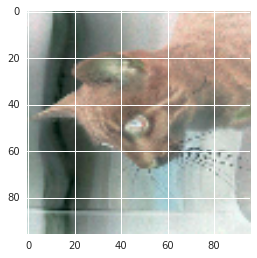

In [11]:
#shows a sample picture 
plt.imshow(train[1].T)

In [12]:
img_width, img_height = 96, 96

train_data_dir = 'train2'
validation_data_dir = 'validation'

nb_train_samples = 12500
nb_validation_samples = 3000
nb_epoch = 10

# Preparing the VGG pre-trained model
(source:Francoise Chollet https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)

In [13]:
import h5py

In [14]:
def VGG_16():
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape=(3,img_width, img_height)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    

    weights_path='vgg16_weights_original.h5'
    #courtesy of xyz on kaggle, this adjust the index for the weights to be loaded into the model, because
    #input image size is not 224
    assert os.path.exists(weights_path), 'Model weights not found (see "weights_path" variable in script).'
    f = h5py.File(weights_path)
    for k in range(f.attrs['nb_layers']):
        if k >= len(model.layers):break
    # we don't look at the last (fully-connected) layers in the savefile
        g = f['layer_{}'.format(k)]
        weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
        model.layers[k].set_weights(weights) #sets the selected weight from pre-trained weight
    f.close()
    print('Model loaded.')

 
    return model

In [15]:
model2=VGG_16()

Model loaded.


In [16]:
from keras.preprocessing.image import ImageDataGenerator

In [17]:
datagen = ImageDataGenerator(rescale=1./255,zoom_range=0.4,)

In [18]:
generator = datagen.flow_from_directory(
            train_data_dir,
            classes=['cats','dogs'], #order, cats first
            target_size=(img_width, img_height),
            batch_size=32,
            class_mode=None,
            shuffle=False)

Found 12500 images belonging to 2 classes.


In [19]:
bottleneck_features_train = model2.predict_generator(generator, nb_train_samples)
#save as numpy array   
np.save(open('bottleneck_features_train(12500).npy', 'w'), bottleneck_features_train)

In [20]:
generator = datagen.flow_from_directory(
            validation_data_dir,
            classes=['cats','dogs'],
            target_size=(img_width, img_height),
            batch_size=32,
            class_mode=None,
            shuffle=False)

Found 3000 images belonging to 2 classes.


In [21]:
bottleneck_features_validation = model2.predict_generator(generator, nb_validation_samples)
np.save(open('bottleneck_features_validation(12500).npy', 'w'), bottleneck_features_validation)

In [22]:
train_data = np.load(open('bottleneck_features_train(12500).npy'))
train_labels = np.array([0] * (nb_train_samples / 2) + [1] * (nb_train_samples / 2))
print(train_data.shape)

(12500, 512, 3, 3)


In [23]:
validation_data = np.load(open('bottleneck_features_validation(12500).npy'))
validation_labels = np.array([0] * (nb_validation_samples / 2) + [1] * (nb_validation_samples / 2))
print(validation_data.shape)

(3000, 512, 3, 3)


In [24]:
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


In [25]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
from keras.callbacks import History 
history = History()
early_stopping=EarlyStopping(monitor='val_loss', patience=4)

In [27]:
model.fit(train_data, train_labels,
              nb_epoch=nb_epoch, batch_size=32,verbose=1,
              validation_data=(validation_data, validation_labels))

#run 10 epochs

Train on 12500 samples, validate on 3000 samples
Epoch 1/10
12500/12500 [==============================] - 0s - loss: 0.4964 - acc: 0.7586 - val_loss: 0.3989 - val_acc: 0.8120
Epoch 2/10
12500/12500 [==============================] - 0s - loss: 0.4172 - acc: 0.8120 - val_loss: 0.3783 - val_acc: 0.8290
Epoch 3/10
12500/12500 [==============================] - 0s - loss: 0.3917 - acc: 0.8266 - val_loss: 0.3733 - val_acc: 0.8280
Epoch 4/10
12500/12500 [==============================] - 0s - loss: 0.3763 - acc: 0.8350 - val_loss: 0.3710 - val_acc: 0.8317
Epoch 5/10
12500/12500 [==============================] - 0s - loss: 0.3639 - acc: 0.8398 - val_loss: 0.3723 - val_acc: 0.8337
Epoch 6/10
12500/12500 [==============================] - 0s - loss: 0.3517 - acc: 0.8483 - val_loss: 0.3785 - val_acc: 0.8237
Epoch 7/10
12500/12500 [==============================] - 0s - loss: 0.3469 - acc: 0.8510 - val_loss: 0.3838 - val_acc: 0.8247
Epoch 8/10
12500/12500 [==============================] - 0s -

In [28]:
model.save_weights('bottleneck_fc_model(dense64).h5')


In [29]:
top_model = Sequential()
top_model.add(Flatten(input_shape=model2.output_shape[1:]))
top_model.add(Dense(64, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

In [30]:
top_model.load_weights('bottleneck_fc_model(dense64).h5')

In [31]:
model2.add(top_model)

In [32]:
# set the first 25 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model2.layers[:25]:
    layer.trainable = False

In [33]:
model2.compile(loss='binary_crossentropy',
              optimizer=SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [34]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        featurewise_center=True
        rotation_range=20,
        shear_range=0.2,
        zoom_range=0.4,
        horizontal_flip=True)

In [35]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [36]:
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        classes=['cats','dogs'],
        target_size=(img_height, img_width),
        batch_size=32,
        class_mode='binary')


Found 12500 images belonging to 2 classes.


In [37]:
validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        classes=['cats','dogs'],
        target_size=(img_height, img_width),
        batch_size=32,
        class_mode='binary')

Found 3000 images belonging to 2 classes.


In [46]:
# fine-tune the model
mf=model2.fit_generator(
        train_generator,
        samples_per_epoch=nb_train_samples,
        nb_epoch=nb_epoch,verbose=1,
        validation_data=validation_generator,
        nb_val_samples=nb_validation_samples)

#Epochs shown below are continuation from the first 10 epochs.


Epoch 1/10
12500/12500 [==============================] - 168s - loss: 0.2667 - acc: 0.8886 - val_loss: 0.2373 - val_acc: 0.9037
Epoch 2/10
12500/12500 [==============================] - 168s - loss: 0.2580 - acc: 0.8937 - val_loss: 0.2322 - val_acc: 0.8987
Epoch 3/10
12500/12500 [==============================] - 168s - loss: 0.2539 - acc: 0.8944 - val_loss: 0.2282 - val_acc: 0.9080
Epoch 4/10
12500/12500 [==============================] - 168s - loss: 0.2435 - acc: 0.8998 - val_loss: 0.2172 - val_acc: 0.9093
Epoch 5/10
12500/12500 [==============================] - 168s - loss: 0.2465 - acc: 0.8974 - val_loss: 0.2202 - val_acc: 0.9060
Epoch 6/10
12500/12500 [==============================] - 168s - loss: 0.2387 - acc: 0.9006 - val_loss: 0.2146 - val_acc: 0.9080
Epoch 7/10
12500/12500 [==============================] - 168s - loss: 0.2347 - acc: 0.9026 - val_loss: 0.2222 - val_acc: 0.9067
Epoch 8/10
12500/12500 [==============================] - 168s - loss: 0.2363 - acc: 0.9026 - val

In [40]:
#normalize the test set by dividing 255 to keep it consistent
test /= 255

In [47]:
predictions = model2.predict(test, verbose=0)


In [48]:
submission=pd.read_csv('sample_submission.csv')
submission.head()

,id,label
0,1,0.5
1,2,0.5
2,3,0.5
3,4,0.5
4,5,0.5


In [49]:
submission['label']=predictions
submission['id']=ID
submission.sort('id', inplace=True)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


In [50]:
submission.head()

,id,label
9536,1,0.994142
4155,2,1.000000
6191,3,1.000000
2618,4,0.999876
10062,5,0.010211


In [51]:
submission.to_csv('TL_prediction.csv', index=False)


## Look at sample prediction

In [ ]:
for i in range(0,50):
    if predictions[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))
    else: 
        print('I am {:.2%} sure this is a Cat'.format(1-predictions[i][0]))
        
    plt.imshow(test[i].T)
    plt.show()